#CECS 456 - Chest X-Ray Pneumonia Classification

Author: Huy Nguyen

This notebook trains deep learning models to classify chest X-ray images as NORMAL or PNEUMONIA using:
- A custom CNN `SmallCNN`
- A transfer learning model based on `ResNet18`

It is designed to run on **Google Colab** with GPU acceleration.

In [1]:
# Colab setup: install required libraries
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install matplotlib scikit-learn tqdm


Looking in indexes: https://download.pytorch.org/whl/cu121


In [2]:
from google.colab import files
print("📥 Please upload your kaggle.json file (Kaggle API Key).")
uploaded = files.upload()





📥 Please upload your kaggle.json file (Kaggle API Key).


Saving kaggle.json to kaggle.json


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle API is now configured.")


Kaggle API is now configured.


In [6]:
# Download dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

# Create data folder and unzip
!mkdir -p data
!unzip -q chest-xray-pneumonia.zip -d data

print("Dataset downloaded & extracted successfully!")


Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.27G/2.29G [00:55<00:00, 170MB/s]
100% 2.29G/2.29G [00:55<00:00, 44.0MB/s]
Dataset downloaded & extracted successfully!


In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, WeightedRandomSampler

from torchvision import datasets, transforms, models

from sklearn.metrics import confusion_matrix, classification_report

from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Path to chest_xray inside Colab
DATA_ROOT = "/content/data/chest_xray"  # works for both Upload and Kaggle unzip

IMG_SIZE = 224
BATCH_SIZE = 32

train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.05, contrast=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

eval_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])


Using device: cuda


In [8]:
# Load datasets
train_ds = datasets.ImageFolder(os.path.join(DATA_ROOT, "train"), transform=train_tf)
val_ds   = datasets.ImageFolder(os.path.join(DATA_ROOT, "val"),   transform=eval_tf)
test_ds  = datasets.ImageFolder(os.path.join(DATA_ROOT, "test"),  transform=eval_tf)

class_names = train_ds.classes
num_classes = len(class_names)
print("Classes:", class_names)

# Handle class imbalance with WeightedRandomSampler
targets = np.array(train_ds.targets)
class_sample_count = np.bincount(targets)
weights = 1.0 / class_sample_count[targets]
sampler = WeightedRandomSampler(weights=weights, num_samples=len(weights), replacement=True)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler,
                          num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=2, pin_memory=True)


Classes: ['NORMAL', 'PNEUMONIA']


## 2. Model definitions

We define two models:

- `SmallCnn`: a simple convolutional neural network built from scratch.  
- `ResNet18Transfer`: a transfer learning model based on ResNet18 pre-trained on ImageNet.  


In [9]:
class SmallCnn(nn.Module):
    """Custom CNN from scratch for chest X-ray classification."""
    def __init__(self, num_classes: int = 2):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(256),
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

class ResNet18Transfer(nn.Module):
    """ResNet18 transfer learning model."""
    def __init__(self, num_classes: int = 2, freeze_backbone: bool = True):
        super().__init__()
        self.backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        if freeze_backbone:
            for p in self.backbone.parameters():
                p.requires_grad = False
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.backbone(x)


## 3. Training and evaluation helpers


In [10]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for x, y in tqdm(loader, desc="train", leave=False):
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * y.size(0)
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    return running_loss / total, correct / total

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []
    for x, y in tqdm(loader, desc="eval", leave=False):
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)

        running_loss += loss.item() * y.size(0)
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(y.cpu().numpy())

    avg_loss = running_loss / total
    acc = correct / total
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    return avg_loss, acc, all_labels, all_preds

def plot_history(history, title_prefix=""):
    epochs = range(1, len(history["train_loss"]) + 1)
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], label="Train")
    plt.plot(epochs, history["val_loss"], label="Val")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title(f"{title_prefix} Loss")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, history["train_acc"], label="Train")
    plt.plot(epochs, history["val_acc"], label="Val")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title(f"{title_prefix} Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

def print_classification_results(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion matrix:\n", cm)
    print("\nClassification report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


## 4. Train and evaluate `SmallCnn`


Epoch 1/5


  Train loss 0.2987 acc 0.8907
  Val   loss 2.8774 acc 0.6250
Epoch 2/5


  Train loss 0.2225 acc 0.9156
  Val   loss 1.2339 acc 0.6250
Epoch 3/5


  Train loss 0.1866 acc 0.9304
  Val   loss 0.7181 acc 0.7500
Epoch 4/5


  Train loss 0.1221 acc 0.9517
  Val   loss 0.7573 acc 0.6250
Epoch 5/5


  Train loss 0.1069 acc 0.9588
  Val   loss 0.6390 acc 0.6250


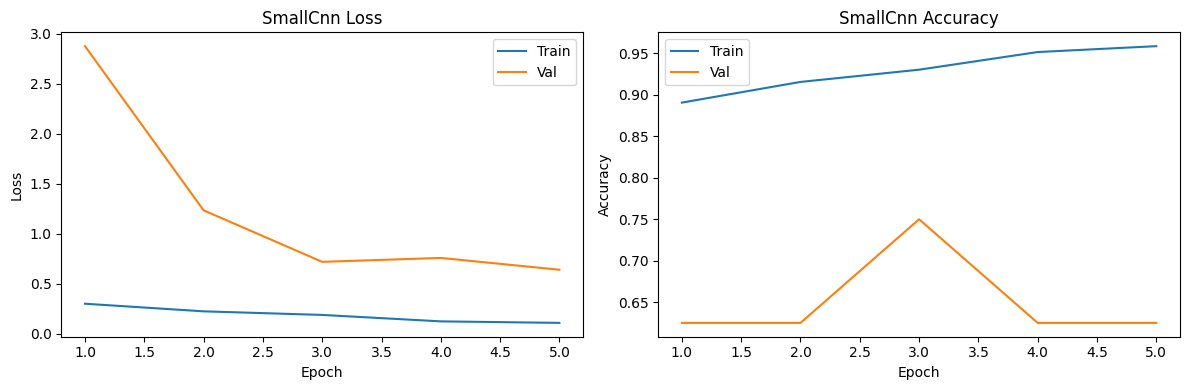

SmallCnn Test loss: 0.5024, Test acc: 0.8574
Confusion matrix:
 [[151  83]
 [  6 384]]

Classification report:

              precision    recall  f1-score   support

      NORMAL     0.9618    0.6453    0.7724       234
   PNEUMONIA     0.8223    0.9846    0.8961       390

    accuracy                         0.8574       624
   macro avg     0.8920    0.8150    0.8343       624
weighted avg     0.8746    0.8574    0.8497       624



In [11]:
EPOCHS_SMALLCNN = 5  # you can increase to 10 if GPU is fast

smallcnn = SmallCnn(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(smallcnn.parameters(), lr=1e-3)
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS_SMALLCNN)

history_small = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

for epoch in range(1, EPOCHS_SMALLCNN + 1):
    print(f"Epoch {epoch}/{EPOCHS_SMALLCNN}")
    tr_loss, tr_acc = train_one_epoch(smallcnn, train_loader, criterion, optimizer, device)
    va_loss, va_acc, _, _ = evaluate(smallcnn, val_loader, criterion, device)
    scheduler.step()

    history_small["train_loss"].append(tr_loss)
    history_small["val_loss"].append(va_loss)
    history_small["train_acc"].append(tr_acc)
    history_small["val_acc"].append(va_acc)

    print(f"  Train loss {tr_loss:.4f} acc {tr_acc:.4f}")
    print(f"  Val   loss {va_loss:.4f} acc {va_acc:.4f}")

plot_history(history_small, title_prefix="SmallCnn")

# Final evaluation on test set
test_loss_small, test_acc_small, y_true_small, y_pred_small = evaluate(smallcnn, test_loader, criterion, device)
print(f"SmallCnn Test loss: {test_loss_small:.4f}, Test acc: {test_acc_small:.4f}")
print_classification_results(y_true_small, y_pred_small, class_names)


## 5. Train and evaluate `ResNet18Transfer`


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 215MB/s]


Epoch 1/5


  Train loss 0.3015 acc 0.8779
  Val   loss 0.2199 acc 0.9375
Epoch 2/5


  Train loss 0.2150 acc 0.9185
  Val   loss 0.1939 acc 0.9375
Epoch 3/5


  Train loss 0.1839 acc 0.9300
  Val   loss 0.2229 acc 0.9375
Epoch 4/5


  Train loss 0.1741 acc 0.9398
  Val   loss 0.2397 acc 0.8750
Epoch 5/5


  Train loss 0.1832 acc 0.9342
  Val   loss 0.2338 acc 0.8750


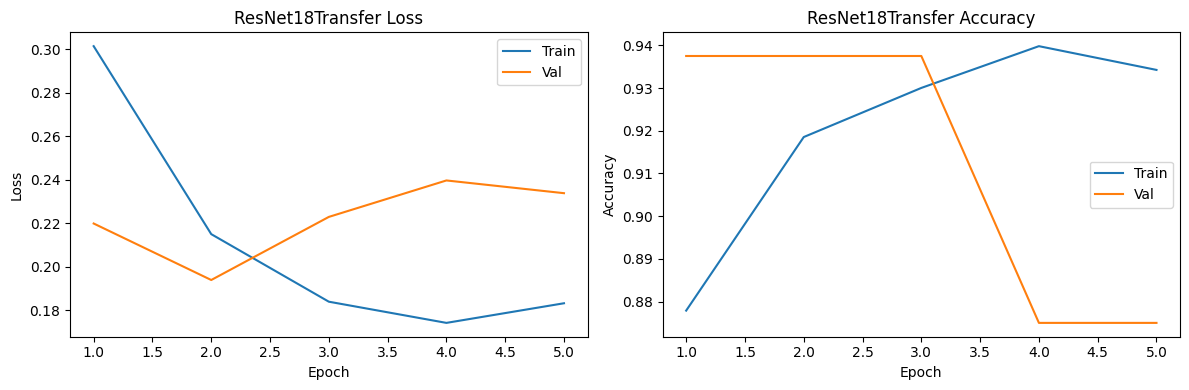

ResNet18Transfer Test loss: 0.2610, Test acc: 0.9071
Confusion matrix:
 [[193  41]
 [ 17 373]]

Classification report:

              precision    recall  f1-score   support

      NORMAL     0.9190    0.8248    0.8694       234
   PNEUMONIA     0.9010    0.9564    0.9279       390

    accuracy                         0.9071       624
   macro avg     0.9100    0.8906    0.8986       624
weighted avg     0.9077    0.9071    0.9059       624



In [12]:
EPOCHS_RESNET = 5  # increase if you want better performance and have time

resnet = ResNet18Transfer(num_classes=num_classes, freeze_backbone=True).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = AdamW([p for p in resnet.parameters() if p.requires_grad], lr=1e-3)
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS_RESNET)

history_resnet = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

for epoch in range(1, EPOCHS_RESNET + 1):
    print(f"Epoch {epoch}/{EPOCHS_RESNET}")
    tr_loss, tr_acc = train_one_epoch(resnet, train_loader, criterion, optimizer, device)
    va_loss, va_acc, _, _ = evaluate(resnet, val_loader, criterion, device)
    scheduler.step()

    history_resnet["train_loss"].append(tr_loss)
    history_resnet["val_loss"].append(va_loss)
    history_resnet["train_acc"].append(tr_acc)
    history_resnet["val_acc"].append(va_acc)

    print(f"  Train loss {tr_loss:.4f} acc {tr_acc:.4f}")
    print(f"  Val   loss {va_loss:.4f} acc {va_acc:.4f}")

plot_history(history_resnet, title_prefix="ResNet18Transfer")

# Final evaluation on test set
test_loss_res, test_acc_res, y_true_res, y_pred_res = evaluate(resnet, test_loader, criterion, device)
print(f"ResNet18Transfer Test loss: {test_loss_res:.4f}, Test acc: {test_acc_res:.4f}")
print_classification_results(y_true_res, y_pred_res, class_names)
